## From tutorial 
#### https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

### Note that there are four hyperparamters that need to be set: 
1. Code Size , i.e, # of nodes in the middle layer (I think this basically means size of latent space)

2. Number of layers - Autoencoder can be as deep as you like. 

3. Number of nodes per layer - typically use stacked autoencoder (sandwich) (need not be symmetric between encoding and decoding but generally is)

4. Loss Function - typically either MSE (mean squared error) or binaray crossentropy (input between 0 and 1)

### Advice

The autoencoder can easily reproduce the original images when expanding the network very deep and the latent space close to the size of the input data. This is not helpful, however, as the network will basically just be creating a convluted version of the identity function or overfit the data and not generalize well. It is best to keep the code size small and employ the sandwiching technique so that the lower dimensionality offers insight into the data. This is called an undercomplete autoencoder. It will be forced to extract meaningful features of the input. 

In [3]:
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings 

warnings.filterwarnings('ignore')

from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

### Utility Functions 

In [31]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)
    
    # number of example digits to show
    n = 5
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        # plot the original images
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')
            
        # plot the reconstructed images
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()
    
def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8,6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' %history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])
        
    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

## MNIST 
### Deep Autoencoder

In [10]:
# Normalize and flatten the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [11]:
# hyperparameters
input_size = 784
hidden_size = 128
code_size = 32

# set layers 
input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1878
Epoch 2/3
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1002
Epoch 3/3
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0951


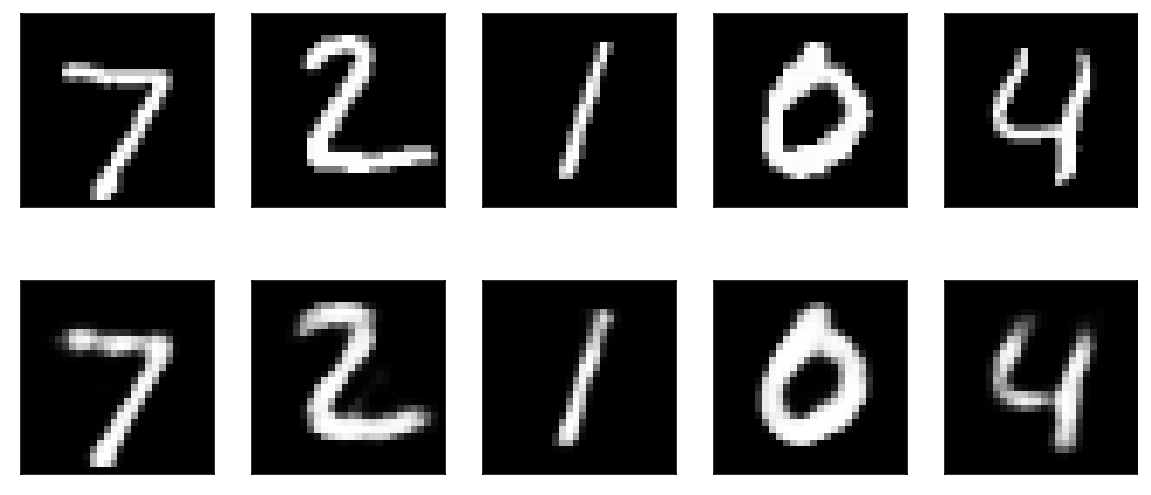

In [12]:
plot_autoencoder_outputs(autoencoder, 5, (28,28))

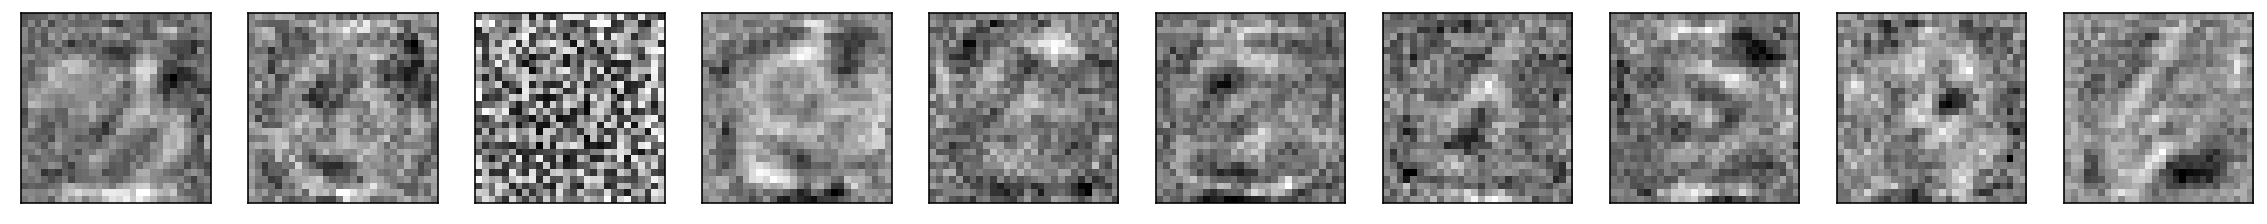

In [13]:
# I think that this section is just showing where most of the activation is happening

weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Shallow Encoder

In [14]:
# Basically the same as before but with no hidden layers and a few more epochs
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 850us/step - loss: 0.2234
Epoch 2/5
1875/1875 [==============================] - 2s 837us/step - loss: 0.1082
Epoch 3/5
1875/1875 [==============================] - 2s 856us/step - loss: 0.0969
Epoch 4/5
1875/1875 [==============================] - 2s 846us/step - loss: 0.0955
Epoch 5/5
1875/1875 [==============================] - 2s 864us/step - loss: 0.0946


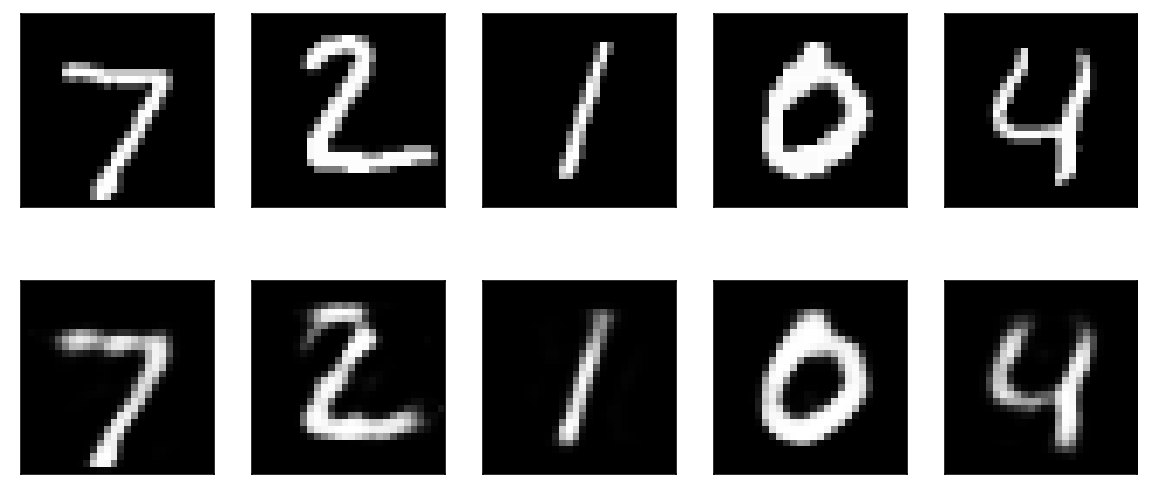

In [15]:
plot_autoencoder_outputs(autoencoder, 5, (28,28))

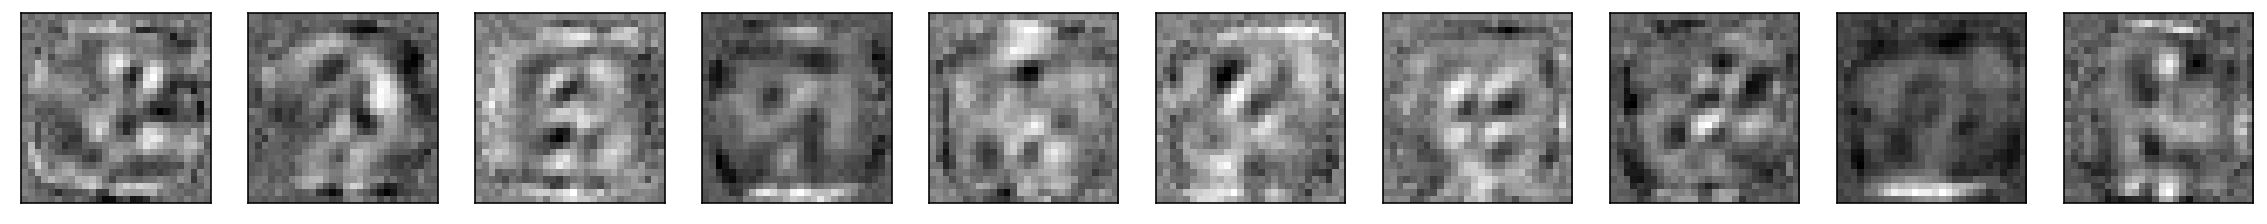

In [16]:
# Again I think this is showing the active weights for our network 

weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+20].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Denoising autoencoder

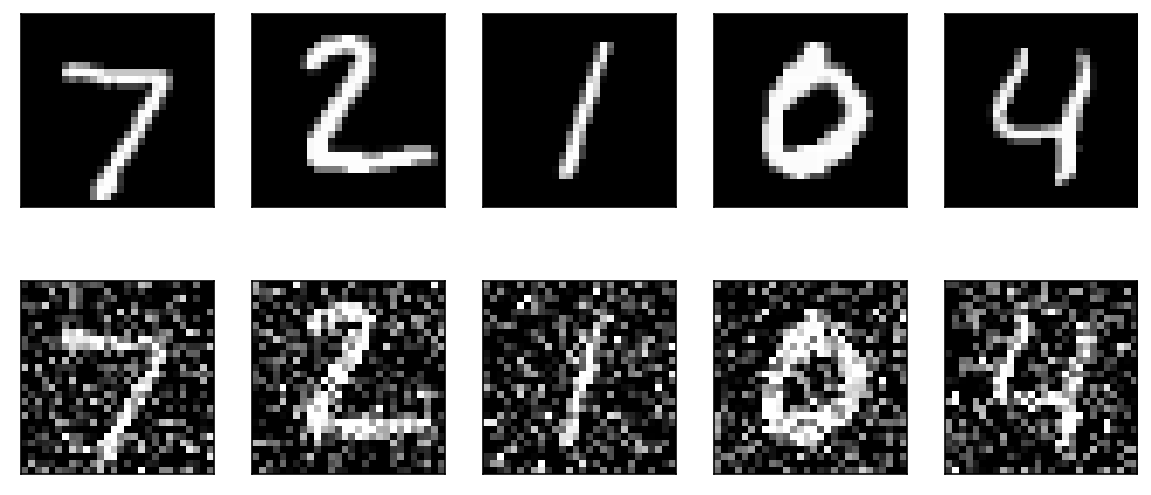

In [17]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

# Visualize the noise adjustments
n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [19]:
# again set the size of the network
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden1)
hidden2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2124
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1298
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1211
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1166
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1142
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1126
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1112
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1103
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1096
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1090


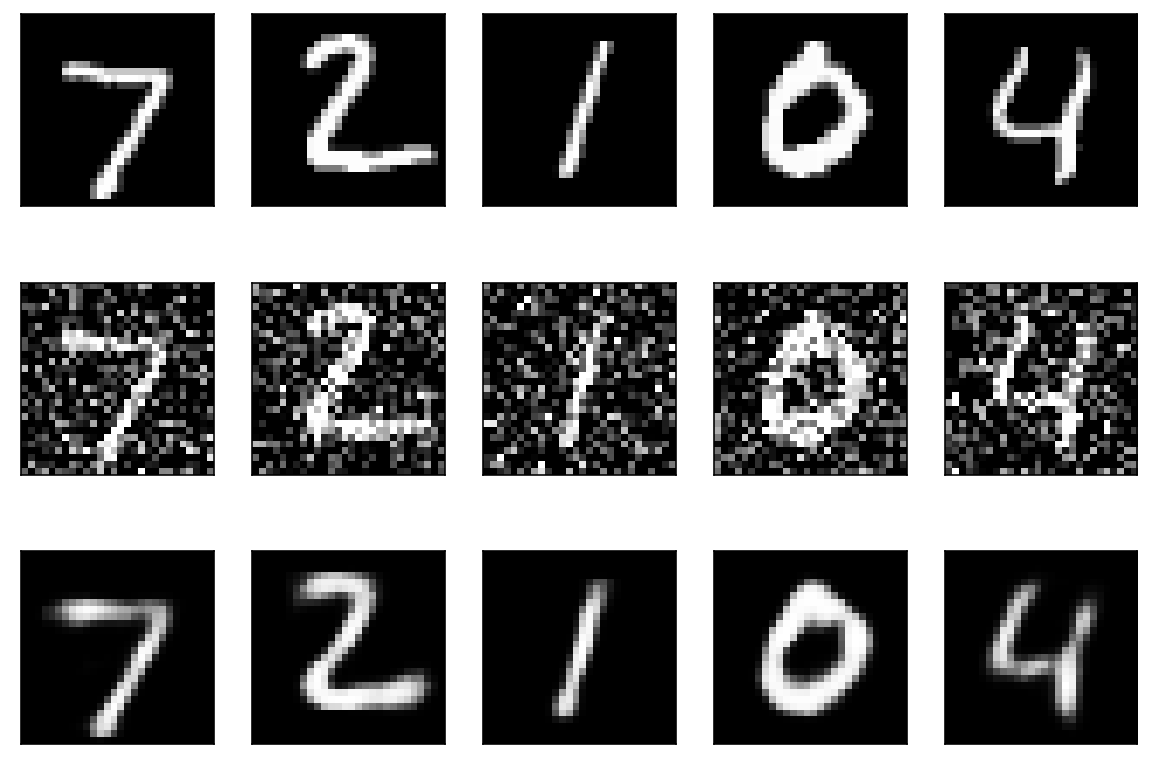

In [20]:
# Plot the original, noisy image, and reconstructed image
n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

### Sparse Autoencoders
For whatever reason, the sparse autoencoder performs worse it seems here, and doesn't even do a good job of changing the distribution of the activation of neurons. something could be typed wrong, I don't care to look for it. 

In [21]:
# This I believe is showing the shallow network without regularization
# so that it can be compared to the below network with regularization

input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
1875/1875 [==============================] - 2s 837us/step - loss: 0.2222
Epoch 2/20
1875/1875 [==============================] - 2s 842us/step - loss: 0.1089
Epoch 3/20
1875/1875 [==============================] - 2s 854us/step - loss: 0.0973
Epoch 4/20
1875/1875 [==============================] - 2s 838us/step - loss: 0.0954
Epoch 5/20
1875/1875 [==============================] - 2s 841us/step - loss: 0.0946
Epoch 6/20
1875/1875 [==============================] - 2s 843us/step - loss: 0.0943
Epoch 7/20
1875/1875 [==============================] - 2s 840us/step - loss: 0.0941
Epoch 8/20
1875/1875 [==============================] - 2s 865us/step - loss: 0.0939
Epoch 9/20
1875/1875 [==============================] - 2s 849us/step - loss: 0.0937
Epoch 10/20
1875/1875 [==============================] - 2s 851us/step - loss: 0.0938
Epoch 11/20
1875/1875 [==============================] - 2s 842us/step - loss: 0.0937
Epoch 12/20
1875/1875 [==============================] - 2s 849

In [34]:
# This is the regularized shallow network

input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

encoded_regularized = Model(input_img, code)

Epoch 1/20
1875/1875 [==============================] - 2s 859us/step - loss: 0.2252
Epoch 2/20
1875/1875 [==============================] - 2s 862us/step - loss: 0.1100
Epoch 3/20
1875/1875 [==============================] - 2s 920us/step - loss: 0.0989
Epoch 4/20
1875/1875 [==============================] - 2s 845us/step - loss: 0.0973
Epoch 5/20
1875/1875 [==============================] - 2s 857us/step - loss: 0.0967
Epoch 6/20
1875/1875 [==============================] - 2s 853us/step - loss: 0.0965
Epoch 7/20
1875/1875 [==============================] - 2s 850us/step - loss: 0.0959
Epoch 8/20
1875/1875 [==============================] - 2s 851us/step - loss: 0.0959
Epoch 9/20
1875/1875 [==============================] - 2s 864us/step - loss: 0.0956
Epoch 10/20
1875/1875 [==============================] - 2s 893us/step - loss: 0.0955
Epoch 11/20
1875/1875 [==============================] - 2s 977us/step - loss: 0.0952
Epoch 12/20
1875/1875 [==============================] - 2s 915

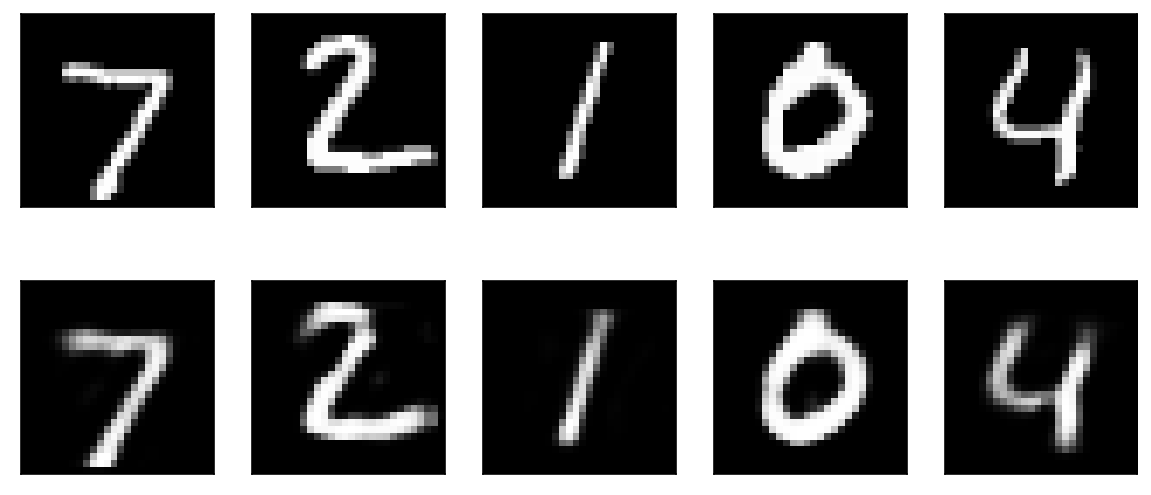

In [35]:
# Plot the 'regularized' reconsturcted images
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

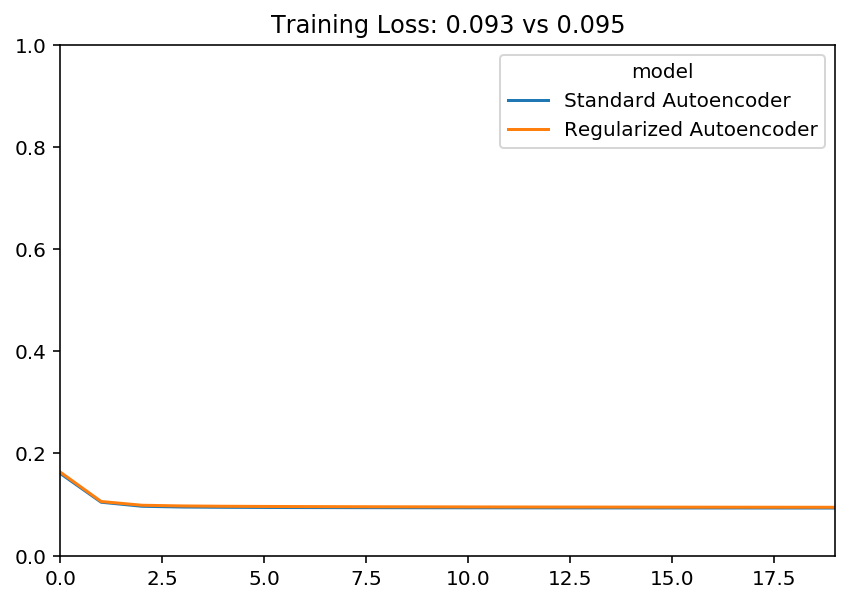

In [36]:
plot_compare_histories([history_standard, history_regularized], 
                       ['Standard Autoencoder', 'Regularized Autoencoder'], plot_accuracy=False)

In [37]:
autoencoder_standard.evaluate(x_test, x_test)


313/313 [==============================] - 0s 602us/step - loss: 0.0921


0.09208595007658005

In [38]:
autoencoder_regularized.evaluate(x_test, x_test)


313/313 [==============================] - 0s 637us/step - loss: 0.0934


0.0934411883354187

In [39]:
print(encoded_standard.predict(x_test).mean())
print(encoded_regularized.predict(x_test).mean())


6.7446804
4.379876


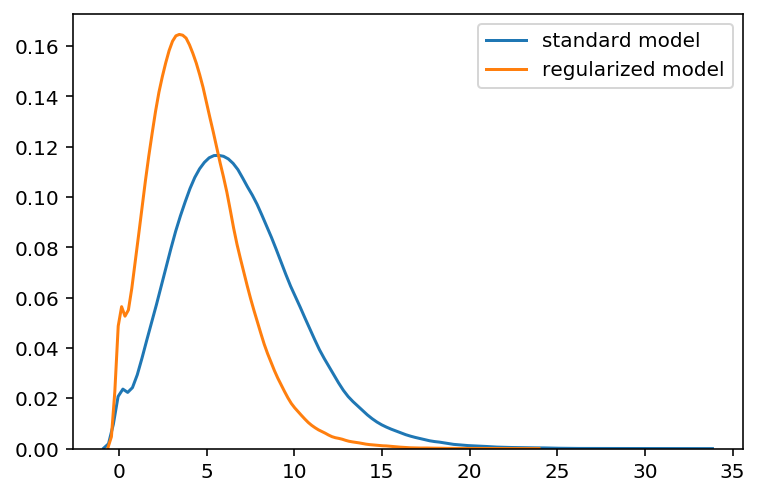

In [40]:
standard_scores = encoded_standard.predict(x_test).ravel()
regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=False, label='standard model')
sns.distplot(regularized_scores, hist=False, label='regularized model')


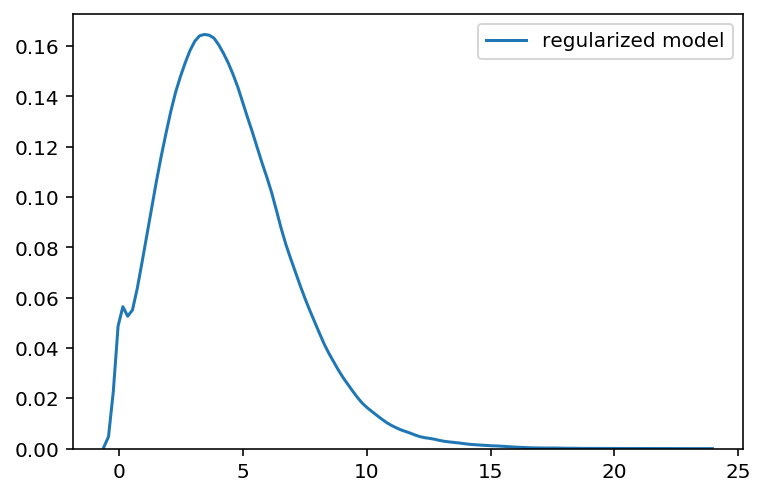

In [41]:
sns.distplot(regularized_scores, hist=False, label='regularized model')
